# FinBERT Sentiment Pipeline for Numerai Signals

## Context
Numerai Signals requires per-stock predictions scored on their **orthogonality** to existing factors. This notebook builds the simplest possible text→feature pipeline: financial sentiment analysis using FinBERT.

## Pipeline
Text headlines → FinBERT sentiment scores → Per-stock aggregation → Numerai Signals format

## Why Start Here
- Establishes the end-to-end pipeline architecture
- All other approaches (embeddings, graphs, probing) plug into this same pipeline
- FinBERT (ProsusAI) achieves ~89% F1 on financial sentiment, far better than VADER (~70%)

## Limitations (important for interview)
- Sentiment alone is probably NOT orthogonal enough — Numerai likely already has sentiment features
- Real value comes from combining with other approaches (notebooks 02-08)

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, pipeline, AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## A: What will I have to do?

Simple sentiment analysis with FinBERT. Grab Finbert from huggingface, and shove it through AutoModelForSentenceClassification. We need a bunch of training docs; I guess FinBERT just classifies entire docs, e.g., elements of the corpus? 

So, pipeline is:
- summarize text
- sentiment scores from text
- associate each text with a stock, aggregate sentiment for stock
- convert to Numerai Signals format

## 1. Load FinBERT
ProsusAI/finbert is a BERT model fine-tuned on financial text (Financial PhraseBank + analyst reports).
Outputs: positive, negative, neutral probabilities per text input.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=device)


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [3]:
tests = finbert([
    "Apple reported record quarterly revenue of $124 billion",
    "Apple's quarterly revenue declined dramatically to $1 billion",
])

In [4]:
print(tests)

[{'label': 'neutral', 'score': 0.5133031010627747}, {'label': 'negative', 'score': 0.9751783609390259}]


## 2. Sample Financial Headlines
In production, these would come from news APIs (Tiingo, Polygon.io, Yahoo Finance) or Common Crawl.
For this demo, we use realistic synthetic headlines mapped to tickers.

In [5]:
# Synthetic financial headlines with tickers and dates
# In production: replace with news API (Tiingo, Polygon.io, Yahoo Finance, or Common Crawl)
headlines_data = [
    # AAPL
    {
        "ticker": "AAPL",
        "date": "2024-01-15",
        "headline": "Apple reports record Q1 revenue driven by iPhone 15 demand",
    },
    {
        "ticker": "AAPL",
        "date": "2024-01-16",
        "headline": "Apple's Vision Pro pre-orders exceed analyst expectations",
    },
    {
        "ticker": "AAPL",
        "date": "2024-01-17",
        "headline": "Apple faces antitrust scrutiny from EU regulators over App Store practices",
    },
    {
        "ticker": "AAPL",
        "date": "2024-01-18",
        "headline": "Apple cuts prices in China amid fierce competition from Huawei",
    },
    {
        "ticker": "AAPL",
        "date": "2024-01-19",
        "headline": "Apple announces expanded share buyback program",
    },
    # MSFT
    {
        "ticker": "MSFT",
        "date": "2024-01-15",
        "headline": "Microsoft Azure revenue grows 30% year-over-year beating estimates",
    },
    {
        "ticker": "MSFT",
        "date": "2024-01-16",
        "headline": "Microsoft's Copilot AI sees rapid enterprise adoption",
    },
    {
        "ticker": "MSFT",
        "date": "2024-01-17",
        "headline": "Microsoft invests additional $10B in OpenAI partnership",
    },
    {
        "ticker": "MSFT",
        "date": "2024-01-18",
        "headline": "Microsoft faces DOJ investigation over cloud market dominance",
    },
    # TSLA
    {
        "ticker": "TSLA",
        "date": "2024-01-15",
        "headline": "Tesla misses Q4 delivery estimates amid production slowdown",
    },
    {
        "ticker": "TSLA",
        "date": "2024-01-16",
        "headline": "Tesla recalls 2 million vehicles over autopilot safety concerns",
    },
    {
        "ticker": "TSLA",
        "date": "2024-01-17",
        "headline": "Tesla Cybertruck deliveries begin but at lower margins than expected",
    },
    {
        "ticker": "TSLA",
        "date": "2024-01-18",
        "headline": "Tesla slashes prices across entire lineup for third time this year",
    },
    {
        "ticker": "TSLA",
        "date": "2024-01-19",
        "headline": "Elon Musk unveils next-gen battery technology at Tesla investor day",
    },
    # JPM
    {
        "ticker": "JPM",
        "date": "2024-01-15",
        "headline": "JPMorgan reports strong Q4 earnings beating all analyst estimates",
    },
    {
        "ticker": "JPM",
        "date": "2024-01-16",
        "headline": "JPMorgan CEO warns of persistent inflation and geopolitical risks",
    },
    {
        "ticker": "JPM",
        "date": "2024-01-17",
        "headline": "JPMorgan expands wealth management division with new acquisitions",
    },
    {
        "ticker": "JPM",
        "date": "2024-01-18",
        "headline": "JPMorgan faces $500M fine for compliance failures in trading desk",
    },
    # NVDA
    {
        "ticker": "NVDA",
        "date": "2024-01-15",
        "headline": "NVIDIA data center revenue surges 400% on insatiable AI chip demand",
    },
    {
        "ticker": "NVDA",
        "date": "2024-01-16",
        "headline": "NVIDIA announces next-gen Blackwell GPU architecture",
    },
    {
        "ticker": "NVDA",
        "date": "2024-01-17",
        "headline": "NVIDIA faces export restrictions on advanced chips to China",
    },
    {
        "ticker": "NVDA",
        "date": "2024-01-18",
        "headline": "NVIDIA partners with major healthcare companies for AI drug discovery",
    },
    # AMZN
    {
        "ticker": "AMZN",
        "date": "2024-01-15",
        "headline": "Amazon Web Services growth re-accelerates to 14% in Q4",
    },
    {
        "ticker": "AMZN",
        "date": "2024-01-16",
        "headline": "Amazon announces largest layoff round in company history",
    },
    {
        "ticker": "AMZN",
        "date": "2024-01-17",
        "headline": "Amazon Prime membership reaches 250 million subscribers globally",
    },
    {
        "ticker": "AMZN",
        "date": "2024-01-18",
        "headline": "FTC files new antitrust suit against Amazon's marketplace practices",
    },
    # META
    {
        "ticker": "META",
        "date": "2024-01-15",
        "headline": "Meta's ad revenue rebounds strongly driven by AI recommendation engine",
    },
    {
        "ticker": "META",
        "date": "2024-01-16",
        "headline": "Meta Reality Labs losses reach $4B in Q4 raising investor concerns",
    },
    {
        "ticker": "META",
        "date": "2024-01-17",
        "headline": "Meta launches open-source Llama 3 model challenging OpenAI",
    },
    {
        "ticker": "META",
        "date": "2024-01-18",
        "headline": "Meta faces regulatory crackdown in EU over data privacy violations",
    },
    # GOOGL
    {
        "ticker": "GOOGL",
        "date": "2024-01-15",
        "headline": "Google Cloud turns profitable for first time in company history",
    },
    {
        "ticker": "GOOGL",
        "date": "2024-01-16",
        "headline": "Google's Gemini AI model faces criticism for inaccurate outputs",
    },
    {
        "ticker": "GOOGL",
        "date": "2024-01-17",
        "headline": "Alphabet announces first-ever dividend payment to shareholders",
    },
    {
        "ticker": "GOOGL",
        "date": "2024-01-18",
        "headline": "DOJ proposes breaking up Google in landmark antitrust case",
    },
    # XOM
    {
        "ticker": "XOM",
        "date": "2024-01-15",
        "headline": "ExxonMobil completes $60B acquisition of Pioneer Natural Resources",
    },
    {
        "ticker": "XOM",
        "date": "2024-01-16",
        "headline": "Oil prices surge on Middle East tensions benefiting ExxonMobil",
    },
    {
        "ticker": "XOM",
        "date": "2024-01-17",
        "headline": "ExxonMobil faces shareholder revolt over climate change strategy",
    },
    {
        "ticker": "XOM",
        "date": "2024-01-18",
        "headline": "ExxonMobil increases quarterly dividend by 5%",
    },
    # PFE
    {
        "ticker": "PFE",
        "date": "2024-01-15",
        "headline": "Pfizer COVID vaccine revenue plummets 70% as pandemic demand fades",
    },
    {
        "ticker": "PFE",
        "date": "2024-01-16",
        "headline": "Pfizer's new cancer drug shows promising Phase 3 trial results",
    },
    {
        "ticker": "PFE",
        "date": "2024-01-17",
        "headline": "Pfizer announces $3.5B cost-cutting program to offset revenue decline",
    },
    {
        "ticker": "PFE",
        "date": "2024-01-18",
        "headline": "Pfizer acquires oncology biotech for $43B to diversify pipeline",
    },
]

df = pd.DataFrame(headlines_data)
df["date"] = pd.to_datetime(df["date"])
print(f"Dataset: {len(df)} headlines across {df['ticker'].nunique()} tickers")
print(f"Tickers: {sorted(df['ticker'].unique())}")

Dataset: 42 headlines across 10 tickers
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'JPM', 'META', 'MSFT', 'NVDA', 'PFE', 'TSLA', 'XOM']


## 3. Score Headlines with FinBERT

In [6]:
# Score all headlines with FinBERT
results = finbert(df["headline"].tolist())

# Extract sentiment scores
df["sentiment_label"] = [r["label"] for r in results]
df["sentiment_score"] = [r["score"] for r in results]

# Convert to numeric: positive=1, neutral=0, negative=-1, weighted by confidence
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
df["sentiment_numeric"] = (
    df["sentiment_label"].map(sentiment_map) * df["sentiment_score"]
)

print("\nSample results:")
for _, row in df.head(8).iterrows():
    print(
        f"  [{row['ticker']}] {row['sentiment_label']:>8s} ({row['sentiment_score']:.3f}) | {row['headline'][:60]}..."
    )


Sample results:
  [AAPL] positive (0.932) | Apple reports record Q1 revenue driven by iPhone 15 demand...
  [AAPL] positive (0.928) | Apple's Vision Pro pre-orders exceed analyst expectations...
  [AAPL] negative (0.950) | Apple faces antitrust scrutiny from EU regulators over App S...
  [AAPL] negative (0.958) | Apple cuts prices in China amid fierce competition from Huaw...
  [AAPL]  neutral (0.713) | Apple announces expanded share buyback program...
  [MSFT] positive (0.952) | Microsoft Azure revenue grows 30% year-over-year beating est...
  [MSFT]  neutral (0.567) | Microsoft's Copilot AI sees rapid enterprise adoption...
  [MSFT] positive (0.636) | Microsoft invests additional $10B in OpenAI partnership...


## 4. Aggregate Per-Stock Features

For Numerai Signals, we need a single prediction per stock. We aggregate headline-level sentiment into stock-level features using multiple statistics.

In [7]:
# Aggregate sentiment features per ticker
agg_features = (
    df
    .groupby("ticker")
    .agg(
        n_headlines=("headline", "count"),
        mean_sentiment=("sentiment_numeric", "mean"),
        std_sentiment=("sentiment_numeric", "std"),
        min_sentiment=("sentiment_numeric", "min"),
        max_sentiment=("sentiment_numeric", "max"),
        pct_positive=("sentiment_label", lambda x: (x == "positive").mean()),
        pct_negative=("sentiment_label", lambda x: (x == "negative").mean()),
        sentiment_range=("sentiment_numeric", lambda x: x.max() - x.min()),
    )
    .reset_index()
)

# Fill NaN std with 0 (single headline tickers)
agg_features["std_sentiment"] = agg_features["std_sentiment"].fillna(0)

print("Per-stock aggregated features:")
print(agg_features.to_string(index=False))

Per-stock aggregated features:
ticker  n_headlines  mean_sentiment  std_sentiment  min_sentiment  max_sentiment  pct_positive  pct_negative  sentiment_range
  AAPL            5       -0.009530       0.941789      -0.957857       0.931807          0.40          0.40         1.889664
  AMZN            4       -0.236972       0.911346      -0.958162       0.953333          0.25          0.50         1.911496
 GOOGL            4       -0.037990       0.714928      -0.949934       0.797975          0.25          0.25         1.747909
   JPM            4       -0.242033       0.913560      -0.959657       0.948946          0.25          0.50         1.908603
  META            4       -0.243983       0.897991      -0.956758       0.923607          0.25          0.50         1.880365
  MSFT            4        0.162655       0.833288      -0.937173       0.952163          0.50          0.25         1.889336
  NVDA            4        0.246268       0.771250      -0.733701       0.935749       

## 5. Format as Numerai Signals Submission

Numerai Signals expects: ticker (from their universe of ~5,000 stocks) + prediction (0 to 1).
We rank-normalize the mean sentiment to [0, 1].

In [8]:
# Create Numerai Signals-style submission
submission = agg_features[["ticker", "mean_sentiment"]].copy()
submission.columns = ["ticker", "signal"]

# Rank-normalize to [0, 1] (Numerai expects percentile-ranked predictions)
submission["signal"] = submission["signal"].rank(pct=True)

print("Numerai Signals submission format:")
print(submission.to_string(index=False))
print(
    f"\nSignal range: [{submission['signal'].min():.3f}, {submission['signal'].max():.3f}]"
)

Numerai Signals submission format:
ticker  signal
  AAPL     0.7
  AMZN     0.4
 GOOGL     0.6
   JPM     0.3
  META     0.2
  MSFT     0.8
  NVDA     0.9
   PFE     1.0
  TSLA     0.1
   XOM     0.5

Signal range: [0.100, 1.000]


## 6. Visualize Results

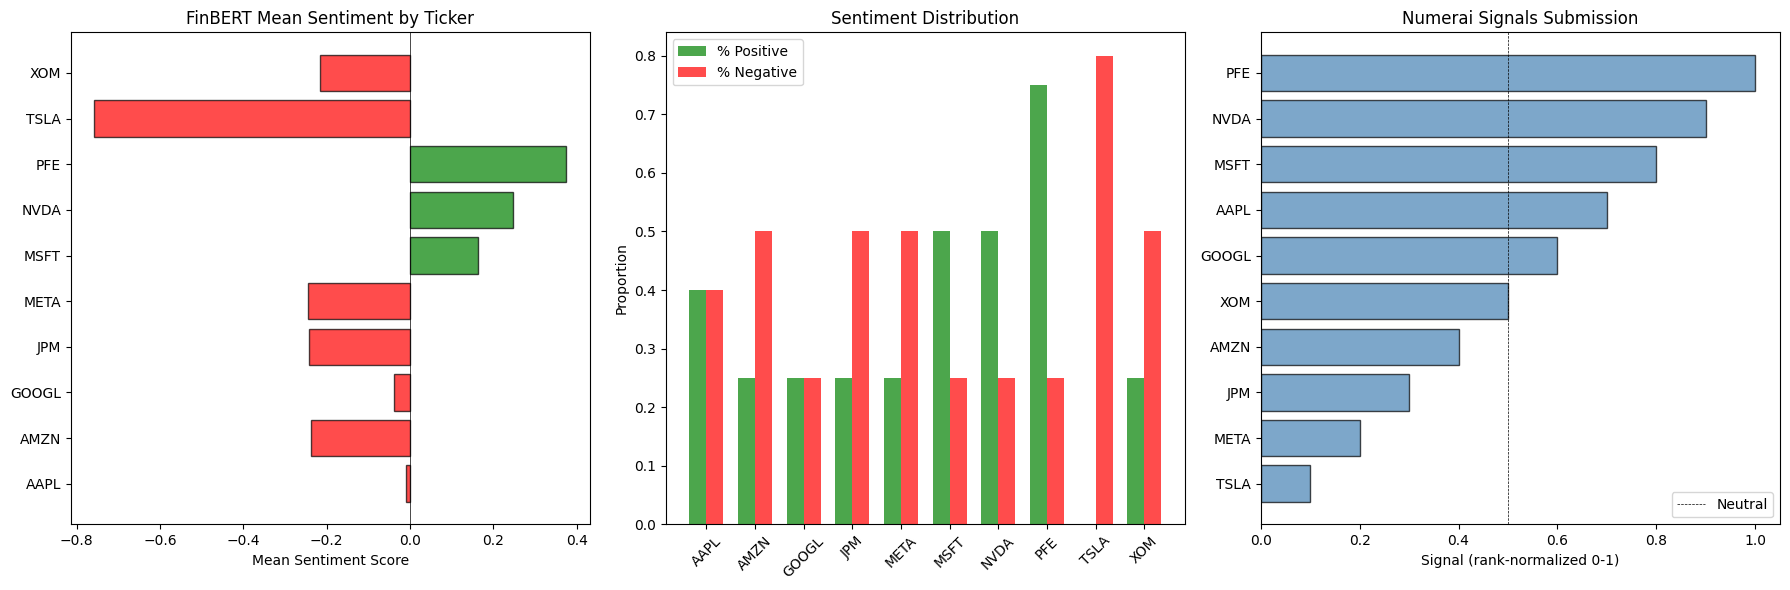

Figure saved: finbert_sentiment_pipeline.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Mean sentiment per ticker
colors = [
    "green" if x > 0 else "red" if x < 0 else "gray"
    for x in agg_features["mean_sentiment"]
]
axes[0].barh(
    agg_features["ticker"],
    agg_features["mean_sentiment"],
    color=colors,
    edgecolor="black",
    alpha=0.7,
)
axes[0].axvline(x=0, color="black", linestyle="-", linewidth=0.5)
axes[0].set_xlabel("Mean Sentiment Score")
axes[0].set_title("FinBERT Mean Sentiment by Ticker")

# Plot 2: Positive vs Negative percentage
x = np.arange(len(agg_features))
width = 0.35
axes[1].bar(
    x - width / 2,
    agg_features["pct_positive"],
    width,
    label="% Positive",
    color="green",
    alpha=0.7,
)
axes[1].bar(
    x + width / 2,
    agg_features["pct_negative"],
    width,
    label="% Negative",
    color="red",
    alpha=0.7,
)
axes[1].set_xticks(x)
axes[1].set_xticklabels(agg_features["ticker"], rotation=45)
axes[1].set_ylabel("Proportion")
axes[1].set_title("Sentiment Distribution")
axes[1].legend()

# Plot 3: Final Numerai Signal (rank-normalized)
submission_sorted = submission.sort_values("signal")
axes[2].barh(
    submission_sorted["ticker"],
    submission_sorted["signal"],
    color="steelblue",
    edgecolor="black",
    alpha=0.7,
)
axes[2].axvline(x=0.5, color="black", linestyle="--", linewidth=0.5, label="Neutral")
axes[2].set_xlabel("Signal (rank-normalized 0-1)")
axes[2].set_title("Numerai Signals Submission")
axes[2].legend()

plt.tight_layout()
plt.savefig("finbert_sentiment_pipeline.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved: finbert_sentiment_pipeline.png")

## 7. Temporal Rolling Features

In production, sentiment should be aggregated over rolling windows to capture momentum and mean-reversion in sentiment.

AAPL temporal sentiment features:
      date                                                                   headline  sentiment_numeric  rolling_mean  sentiment_momentum
2024-01-15                 Apple reports record Q1 revenue driven by iPhone 15 demand           0.931807      0.931807                 NaN
2024-01-16                  Apple's Vision Pro pre-orders exceed analyst expectations           0.927904      0.929855           -0.003903
2024-01-17 Apple faces antitrust scrutiny from EU regulators over App Store practices          -0.949503      0.303403           -1.877407
2024-01-18             Apple cuts prices in China amid fierce competition from Huawei          -0.957857     -0.011912           -0.008354
2024-01-19                             Apple announces expanded share buyback program           0.000000     -0.009530            0.957857


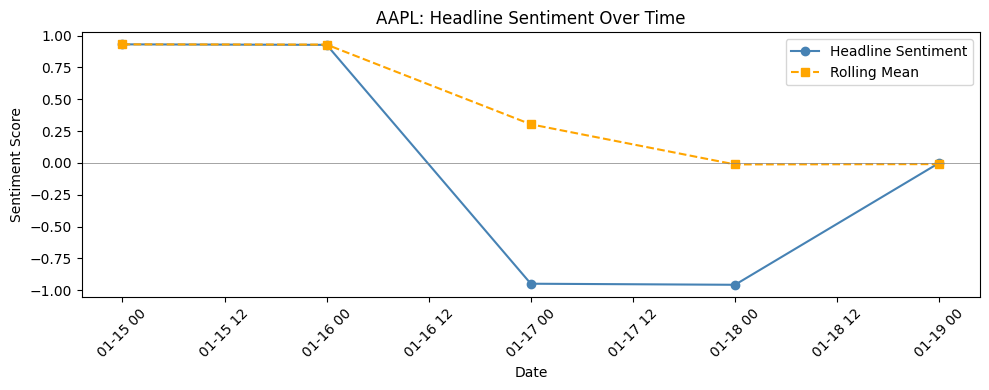

In [10]:
# Demonstrate rolling sentiment aggregation for a single ticker
aapl = df[df["ticker"] == "AAPL"].sort_values("date").copy()

# Expanding (cumulative) statistics
aapl["rolling_mean"] = aapl["sentiment_numeric"].expanding().mean()
aapl["rolling_std"] = aapl["sentiment_numeric"].expanding().std().fillna(0)
aapl["sentiment_momentum"] = aapl["sentiment_numeric"].diff()  # day-over-day change

print("AAPL temporal sentiment features:")
print(
    aapl[
        ["date", "headline", "sentiment_numeric", "rolling_mean", "sentiment_momentum"]
    ].to_string(index=False)
)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    aapl["date"],
    aapl["sentiment_numeric"],
    "o-",
    label="Headline Sentiment",
    color="steelblue",
)
ax.plot(aapl["date"], aapl["rolling_mean"], "s--", label="Rolling Mean", color="orange")
ax.axhline(y=0, color="gray", linestyle="-", linewidth=0.5)
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment Score")
ax.set_title("AAPL: Headline Sentiment Over Time")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Discussion & Interview Talking Points

### Strengths
- **Simple, interpretable pipeline**: Easy to debug, explain, and iterate
- **Fast to deploy**: FinBERT inference is fast (~100 headlines/sec on GPU)
- **Well-validated**: FinBERT achieves 89% F1 on Financial PhraseBank

### Weaknesses & Why This Alone Won't Win
- **Probably not orthogonal**: Numerai likely already has sentiment features. After neutralization, most of this signal will be removed.
- **Coarse granularity**: Positive/negative/neutral misses nuance (e.g., "beat estimates by 1%" vs "beat estimates by 50%")
- **Headline-only**: Headlines are noisy and may not capture the full story

### What Makes This Valuable
- **It's the pipeline, not the model**: This same pipeline (text → score → aggregate → submit) is reused by every other notebook
- **Baseline to beat**: If embeddings (NB02), graphs (NB04), or probing (NB06) can't beat FinBERT sentiment, they're not worth the complexity

### Numerai-Specific Considerations
- **Point-in-time**: Only use headlines published BEFORE the prediction date
- **Low churn**: Smooth features over time (exponential decay) to avoid high-turnover signals
- **Ticker mapping**: In production, must map company names to Numerai's stock universe (~5,000 tickers)

### Extensions (TODO)
- [ ] Replace synthetic headlines with real news API (Tiingo, Polygon.io, Yahoo Finance)
- [ ] Add exponential decay weighting (recent headlines matter more)
- [ ] Compare FinBERT vs VADER vs LLM-based sentiment
- [ ] Backtest against actual stock returns
- [ ] Submit to Numerai Signals and measure orthogonality score